# Week 2 — Conflict Classification & MLflow Experiment Tracking

**Purpose:**  
This notebook aims to build and evaluate models that classify students into high vs. low conflict levels based on their social media behavior, sleep patterns, and mental health scores. We will also set up and use **MLflow** to track experiments, compare model performances, and version our outputs for reproducibility and collaboration.


# Setup and Imports


In [1]:
%load_ext autoreload
%autoreload 2

# Standard library imports
import pickle
import warnings

# Third-party imports
import matplotlib.pyplot as plt
import mlflow
import mlflow.data
import mlflow.sklearn
from mlflow.data.pandas_dataset import PandasDataset
from mlflow.models.signature import infer_signature
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
import shap
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    StandardScaler
)
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

import sys
sys.path.append('../src')
from utils import (    
    create_binary_conflict, 
    continent_dict,
    RareCategoryGrouper,
    CountryToContinentMapper,
    get_feature_names,
    mlflow_dataset,
    run_classification_experiment,
    run_classification_gridsearch_experiment,
    run_shap_experiment
)

# Set random seed for reproducibility
np.random.seed(42)


/opt/anaconda3/envs/c29env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# MLflow Setup


In [2]:
# Set MLflow tracking URI to local directory
mlflow.set_tracking_uri("file:../mlruns")

# Create or get experiment
experiment_name = "Classification_Conflicts"
mlflow.set_experiment(experiment_name)


<Experiment: artifact_location='file:///Users/bobhosseini/Portfolio/SDS-social-sphere/submissions/team-members/bob-hosseini/notebooks/../mlruns/893441246500907044', creation_time=1749911245020, experiment_id='893441246500907044', last_update_time=1749911245020, lifecycle_stage='active', name='Classification_Conflicts', tags={'mlflow.sharedViewState.acb6d7554a592a34fe5dfdfa2dd78e66e549d816cb3ef47109f1b0108d483e80': 'deflate;eJxdksFu2zAMhl9l0DkY2qtvbpZuxZJhcLpgQDCkikTHBGTJEKkuXpF3H+W4dZIjP/4/KYp8UwQ6muYRHUNUhVIzFaKF+NB/h15izRxxnxjoM7GOvGNsYRKVZFRRa0cwU0P+OacLVS6XInJYg+mNg4/ypWF8zX6rWRMwvWe2f2aqDRbcBiJh8JPDuU9V8iQeAgeGwc6DS62QYnv5vJd1SNHAiwgv6SoXpVv65dz+Fo/NM25BsBGmjUlRm/4K1vc7MiHCFYzB7HQymXU66lYQcdQMBzHLfFHGWBw77S1YVbydzuQnep/j7aj4htaCn+INEu7RIfcr3U22syxPJ5/0+FStn3f3d7vq14+1tH9F+LvSR2zxXy49LkhsSyR+bzBSpNLIKFbmrmBY64UlEXyNIXVgN9oloCc/b2TL8vcck+QbtLBoO+6v8SF7HuR+fHJuDG9G14lDBXUEahZe713mo9mFvXZL9DAUnQdf40FM6lgekc5nSQzdcGAe1m0I3Hgg6X43HcnvLF4Nqzlb1On0H/lADH4='}>

# Loading cleand data



In [3]:
# Load cleaned data
with open('../data/data_cleaned.pickle', 'rb') as f:
    df_data = pickle.load(f)

# Display basic information
print("Dataset shape:", df_data.shape)
print("\nTarget variable distribution:")
print(df_data['Conflicts'].value_counts())
df_data.head()


Dataset shape: (702, 13)

Target variable distribution:
Conflicts
3    261
2    204
4    172
1     47
5     15
0      3
Name: count, dtype: int64


,Student_ID,Age,Gender,Academic_Level,Country,Daily_Usage,Platform,Academic_Affects,Sleep_Hrs,Mental_Health,Relationship_Status,Conflicts,Addicted_Score
0,1,19,Female,Undergraduate,Bangladesh,5.2,Instagram,Yes,6.5,6,In Relationship,3,8
1,2,22,Male,Graduate,India,2.1,Twitter,No,7.5,8,Single,0,3
2,3,20,Female,Undergraduate,USA,6.0,TikTok,Yes,5.0,5,Complicated,4,9
3,4,18,Male,High School,UK,3.0,YouTube,No,7.0,7,Single,1,4
4,5,21,Male,Graduate,Canada,4.5,Facebook,Yes,6.0,6,In Relationship,2,7


In [4]:
# find and print numeric columns
numeric_cols = df_data.select_dtypes(include=['number']).columns
print(numeric_cols)


Index(['Student_ID', 'Age', 'Daily_Usage', 'Sleep_Hrs', 'Mental_Health',
       'Conflicts', 'Addicted_Score'],
      dtype='object')


# Target Variable Creation and Class Analysis
- Creating binary target variable
- The minority class is about 30% of the majority class
- As the first try, we try class weighting first before doing any data resampling.

## Target creation and class analysis

Binary Conflict Classification:
Threshold: 3
Low Conflict (0-3): 515 samples
High Conflict (4-max): 187 samples
Class imbalance ratio: 36.31%
Class proportions:
Conflict_Binary
Low     0.733618
High    0.266382
Name: count, dtype: float64


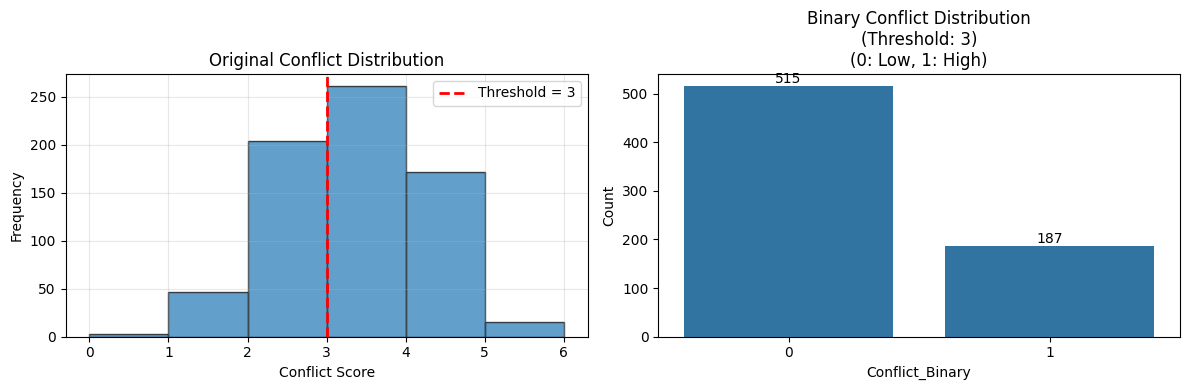

In [5]:
# create target variable using create_binary_conflict
df_data, results = create_binary_conflict(df_data, target_column='Conflicts', threshold=3, visualize=True)
   

# Test train split
- The train split is used for the modeling part.
- The test split is not involved in the modeling phase.

In [6]:
# split the data into train and test
from sklearn.model_selection import train_test_split

drop_cols = ['Student_ID', 'Addicted_Score', 'Conflict_Binary', 'Conflicts']

X_train_full, X_test, y_train_full, y_test = train_test_split(df_data.drop(columns=drop_cols), df_data['Conflict_Binary'], test_size=0.2, random_state=42)

# print the shape of the train and test sets
print(f"Train set shape: {X_train_full.shape}")
print(f"Test set shape: {X_test.shape}")

# print the shape of the train and test sets
print(f"Train set shape: {X_train_full.shape}")
print(f"Test set shape: {X_test.shape}")

X_train_full.head()

Train set shape: (561, 10)
Test set shape: (141, 10)
Train set shape: (561, 10)
Test set shape: (141, 10)


,Age,Gender,Academic_Level,Country,Daily_Usage,Platform,Academic_Affects,Sleep_Hrs,Mental_Health,Relationship_Status
166,20,Female,Undergraduate,Bangladesh,4.9,Instagram,Yes,6.4,5,Single
546,20,Female,Undergraduate,UAE,6.9,Instagram,Yes,6.1,5,In Relationship
285,21,Male,Graduate,UK,5.0,Facebook,Yes,6.6,6,In Relationship
362,20,Female,Undergraduate,Ireland,4.5,TikTok,Yes,7.4,7,Single
111,21,Female,Undergraduate,India,5.8,TikTok,Yes,5.9,6,In Relationship


# Preprocessing Pipeline
- Feature engineering by converting categorical features to numerical variables
- Scaling numerical features

## Define Column Groups

In [7]:
binary_cats       = ['Gender']         # boolean → 0/1
low_card_cols     = ['Relationship_Status', 'Academic_Level']                # few categories
high_card_cols    = ['Platform']                      # group rare then OHE
country_col       = ['Country']                                 # map to continent
numeric_cols      = df_data.drop(columns=drop_cols).select_dtypes(include=['number']).columns

## Defining the Preprocessing steps


In [8]:
# Boolean → int
binary_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

# Low-cardinality One-Hot
low_card_transformer = OneHotEncoder(handle_unknown='ignore')

# High-cardinality grouping + One-Hot
high_card_transformer = Pipeline([
    ('group_rare', RareCategoryGrouper(min_count=30)),
    ('onehot',    OneHotEncoder(handle_unknown='ignore'))
])

# Country → Continent → One-Hot
country_transformer = Pipeline([
    ('map_continent', CountryToContinentMapper(mapping=continent_dict)),
    ('onehot',        OneHotEncoder(handle_unknown='ignore'))
])

# Numeric scaling
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('bools',   binary_transformer,   binary_cats),
    ('low_ohe', low_card_transformer, low_card_cols),
    ('high_ohe',high_card_transformer,high_card_cols),
    ('cty_ohe', country_transformer,  country_col),
    ('nums',    numeric_transformer,  numeric_cols),
], remainder='drop')

## Apply preprocessing and inspect transformed features

Transformed feature matrix (first 5 rows):
   Gender_Male  Relationship_Status_Complicated  \
0          0.0                              0.0   
1          0.0                              0.0   
2          1.0                              0.0   
3          0.0                              0.0   
4          0.0                              0.0   

   Relationship_Status_In Relationship  Relationship_Status_Single  \
0                                  0.0                         1.0   
1                                  1.0                         0.0   
2                                  1.0                         0.0   
3                                  0.0                         1.0   
4                                  1.0                         0.0   

   Academic_Level_Graduate  Academic_Level_High School  \
0                      0.0                         0.0   
1                      0.0                         0.0   
2                      1.0                         0.0 

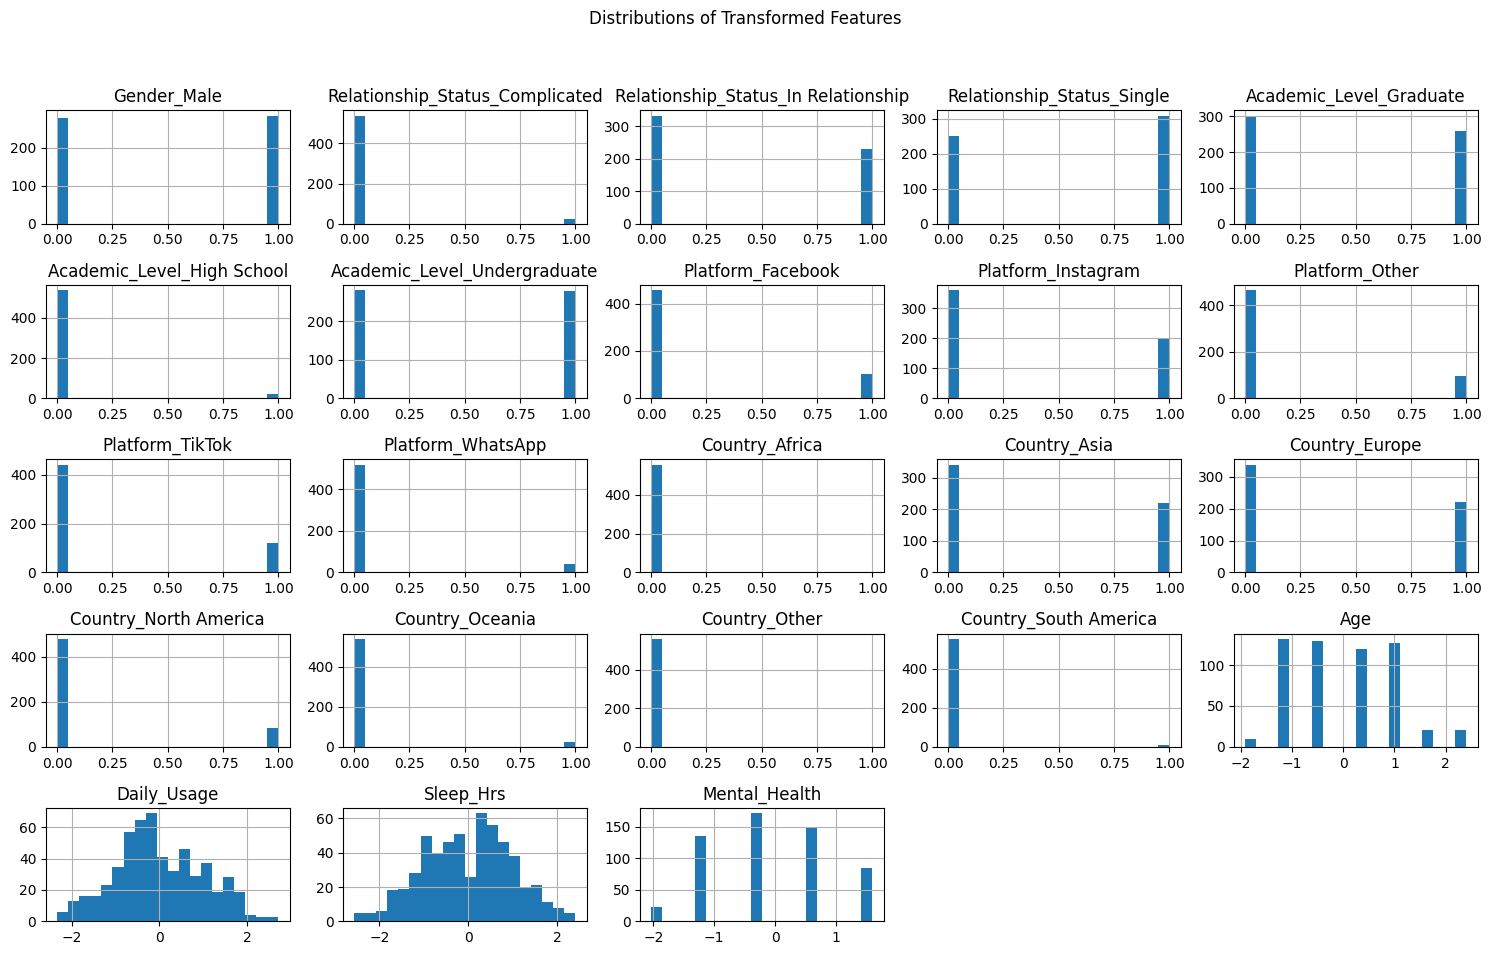

In [9]:
# 1. Fit the preprocessing step on the training data
preprocessor.fit(X_train_full)

# 2. Transform the training data
X_train_proc = preprocessor.transform(X_train_full)

# 3. Retrieve the transformed feature names
#    Note: get_feature_names_out is available on ColumnTransformer in sklearn >=1.0
# from utils import get_feature_names
feature_names = get_feature_names(preprocessor)

# 4. Convert to DataFrame (densify if sparse)
if sparse.issparse(X_train_proc):
    X_train_proc = X_train_proc.toarray()

X_train_df = pd.DataFrame(X_train_proc, columns=feature_names)

# 5. Print the first few rows
print("Transformed feature matrix (first 5 rows):")
print(X_train_df.head())

# 6. Simple visualization: histograms for each feature
X_train_df.hist(bins=20, figsize=(15, 10))
plt.suptitle("Distributions of Transformed Features")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Sample data for MLflow logging

In [10]:
# after fitting your pipeline:
example_input = X_train_full.iloc[:5].copy()
# Convert integer columns to float
for col in example_input.select_dtypes(include=['int64']).columns:
    example_input[col] = example_input[col].astype('float')  

    # 1. Create Dataset objects for each split
train_ds = mlflow.data.from_pandas(
    df=X_train_full,
    source="../data/data_cleaned.pickle",
    name="social_sphere_train_v1"
)
test_ds = mlflow.data.from_pandas(
    df=X_test,
    source="../data/data_cleaned.pickle",
    name="social_sphere_test_v1"
)      
# from utils import mlflow_dataset
mlflow_dataset = mlflow_dataset(X_train_full, X_test)

/opt/anaconda3/envs/c29env/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/data_cleaned.pickle'. Exception: 
  return _dataset_source_registry.resolve(
/opt/anaconda3/envs/c29env/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/opt/anaconda3/envs/c29env/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '../data/data_cleaned.pickle'. Exception: 
  return _dataset_source_registry.resolve(
/opt/anaconda3/envs/c29env/lib/python3.12/site-packages/mlflow/data/dataset_source_re

# Classification pipeline: baseline model

## Cross validation setup
We will use cross-validation to evaluate the performance of the model.

In [11]:
# Define cross-validation settings
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,         # if you want to shuffle before splitting
    random_state=42       # ◀️ fix the RNG here
)
scoring = {
    "accuracy":   "accuracy",
    "precision":  "precision",
    "recall":     "recall",
    "f1_score":         "f1",
    "roc_auc":    "roc_auc"
}

## Train, evaluate, and log a baseline model

As the baseline model, we will use a dummy classifier that predicts the target variable based on these strategies:
- most_frequent
- prior
- uniform
- stratified

We will log the model to MLflow.

In [12]:
param_grid = {
    'classifier__strategy': ['most_frequent', 'prior', 'uniform', 'stratified']
}

baseline_pipeline = Pipeline([
        ("preprocessing", preprocessor),
        ("classifier", DummyClassifier(random_state=42))
    ])
best_logreg, grid_search_result = run_classification_gridsearch_experiment(
    name="baseline_gridsearch_f1",
    pipeline=baseline_pipeline,
    param_grid=param_grid,
    X_train=X_train_full,
    y_train=y_train_full,
    X_test=X_test,
    y_test=y_test,
    cv=cv,
    scoring=scoring,
    dataset=mlflow_dataset,
    registered_model_name=f"conflict_baseline"
)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


Registered model 'conflict_baseline' already exists. Creating a new version of this model...
Created version '3' of model 'conflict_baseline'.


# Classification Pipeline Logistic Regression
- Hyperparameter search is done using GridSearchCV
- The best model is selecetd based on the f1-score metric
- The best model has ```{f1-score: 0.93, precision: 0.95, recall: 0.92}```

In [13]:
# Create the pipeline with the parameters
lr_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])
# Update just the classifier’s params
# lr_pipeline.set_params(**{f"classifier__{k}": v for k, v in lr_params.items()})


# 1. Define the parameter grid (note the double-underscore syntax):
param_grid_lr = {
    # tune LogisticRegression.C
    'classifier__C':       [0.01, 0.1, 1, 10],
    # tune penalty type (use solver that supports L1)
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver':  ['liblinear', 'saga'],
    # class_weight
    'classifier__class_weight': ['balanced', None]
}

# from utils import run_classification_gridsearch_experiment

best_logreg, grid_search_result = run_classification_gridsearch_experiment(
    name="logreg_gridsearch_f1",
    pipeline=lr_pipeline,
    param_grid=param_grid_lr,
    X_train=X_train_full,
    y_train=y_train_full,
    X_test=X_test,
    y_test=y_test,
    cv=cv,
    scoring=scoring,
    dataset=mlflow_dataset,
    registered_model_name=f"conflict_lr"
)

# 3. Print summary in the output cell
print("Best parameters:", grid_search_result.best_params_)
print("Best F1 score (CV):", grid_search_result.best_score_)

# 4. (Optional) inspect all CV results
cv_df = pd.DataFrame(grid_search_result.cv_results_)
display(cv_df.sort_values("mean_test_f1_score", ascending=False).head())

Fitting 5 folds for each of 32 candidates, totalling 160 fits


/opt/anaconda3/envs/c29env/lib/python3.12/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
/Users/bobhosseini/Portfolio/SDS-social-sphere/submissions/team-members/bob-hosseini/notebooks/../src/utils.py:525: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


Best parameters: {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best F1 score (CV): 0.9320475019359918


Registered model 'conflict_lr' already exists. Creating a new version of this model...
Created version '35' of model 'conflict_lr'.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__class_weight,param_classifier__penalty,param_classifier__solver,params,split0_test_accuracy,...,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,split3_train_roc_auc,split4_train_roc_auc,mean_train_roc_auc,std_train_roc_auc
22,0.004535,0.000771,0.007077,0.001355,1.0,None,l2,liblinear,"{'classifier__C': 1, 'classifier__class_weight...",0.955752,...,0.992506,0.003141,12,0.994176,0.995010,0.995085,0.995264,0.994321,0.994771,0.000437
23,0.012773,0.005380,0.009096,0.001985,1.0,None,l2,saga,"{'classifier__C': 1, 'classifier__class_weight...",0.955752,...,0.993159,0.002684,1,0.994125,0.995061,0.995289,0.995365,0.994678,0.994904,0.000457
30,0.005053,0.000760,0.008649,0.003289,10.0,None,l2,liblinear,"{'classifier__C': 10, 'classifier__class_weigh...",0.955752,...,0.992654,0.002299,9,0.994764,0.995821,0.996308,0.995696,0.995111,0.995540,0.000544
20,0.007706,0.003072,0.007886,0.002678,1.0,None,l1,liblinear,"{'classifier__C': 1, 'classifier__class_weight...",0.946903,...,0.993074,0.002078,2,0.994100,0.995061,0.995391,0.994907,0.994754,0.994843,0.000427
31,0.029672,0.004118,0.006838,0.000491,10.0,None,l2,saga,"{'classifier__C': 10, 'classifier__class_weigh...",0.955752,...,0.992979,0.002192,3,0.994840,0.995694,0.996409,0.995773,0.995238,0.995591,0.000529


## Apply SHAP to the best model
- SHAP values figure shows that the most important features are:
    - Mental Health
        - High mental health scores (blue) push toward lower conflict (left).
        - Low mental health scores (red) push toward higher conflict (right).
        - Likely a protective factor — more mentally stable individuals report fewer conflicts.
    - Average Daily Usage Hours
        - High usage (red) increases conflict (pushed right).
        - Low usage (blue) decreases conflict.
        - Supports the hypothesis: heavy usage correlates with conflict.
    - Sleep Hours:
        - Low sleep (red) pushes right (higher conflict).
        - High sleep (blue) pushes left.

- However, the mental health score is determined by the student's self-perception, which may not be externally observable.

/opt/anaconda3/envs/c29env/lib/python3.12/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
/Users/bobhosseini/Portfolio/SDS-social-sphere/submissions/team-members/bob-hosseini/notebooks/../src/utils.py:525: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


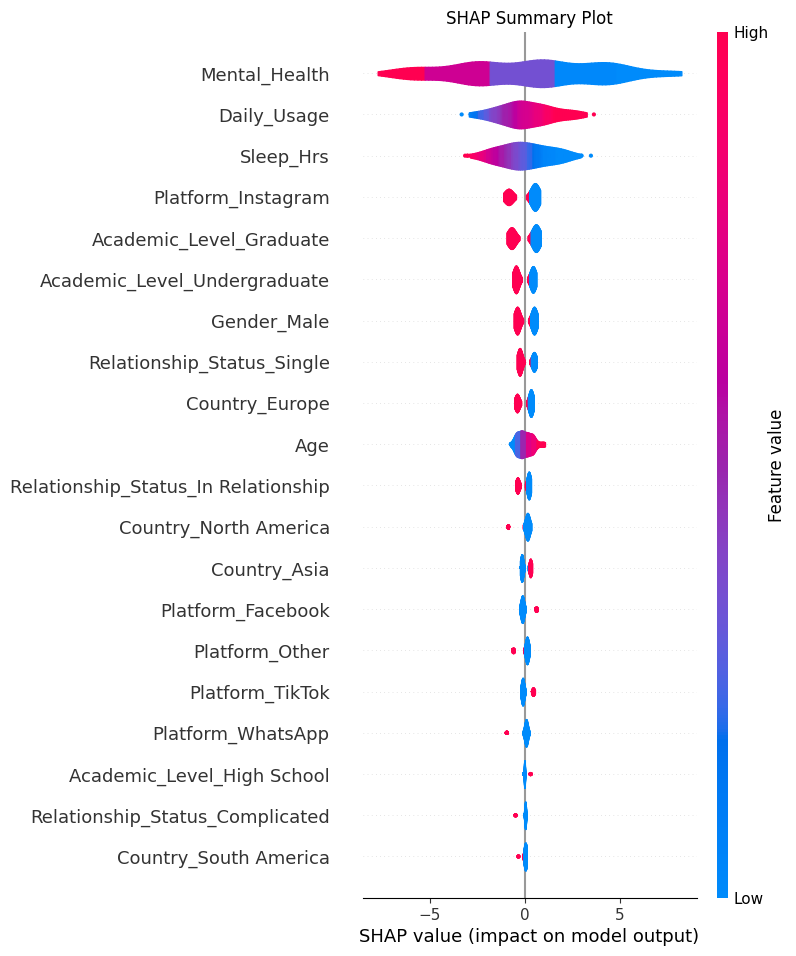

In [14]:
fig_sum = run_shap_experiment(
    best_model=best_logreg,
    X_train_full=X_train_full,
    feature_perturbation="interventional",
    plot_type="violin", # other options: "bar", "dot", "violin"
    shap_type="linear"
)

fig_sum

# Classification Pipeline: XGBoost
- Hyperparameter search is done using GridSearchCV
- The best model is selecetd based on the f1-score metric
- The best model has ```{f1-score: 0.95, precision: 0.97, recall: 0.94}```
    - overal performance is slightly better than the logistic regression model

In [15]:
from xgboost import XGBClassifier

# Instantiate the XGBoost classifier
xgb_clf = XGBClassifier(
    # use_label_encoder=False,   # disables the legacy label encoder warning
    eval_metric='logloss',     # default evaluation metric for binary
    random_state=42,
    n_jobs=-1
)

# 2. Build the full pipeline
xgb_pipeline = Pipeline([
    ('preprocessing', preprocessor),   # your ColumnTransformer from earlier
    ('classifier',     xgb_clf)
])


# Define a param grid for GridSearchCV
xgb_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth':    [3, 5, 7],
    'classifier__learning_rate':[0.01, 0.1],
    'classifier__subsample':    [0.8, 1.0]
}

best_xgb, grid_search_result = run_classification_gridsearch_experiment(
    name="xgb_gridsearch_f1",
    pipeline=xgb_pipeline,
    param_grid=xgb_param_grid,
    X_train=X_train_full,
    y_train=y_train_full,
    X_test=X_test,
    y_test=y_test,
    cv=cv,
    scoring=scoring,
    dataset=mlflow_dataset,
    registered_model_name=f"conflict_xgb",
    verbose=True
)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
accuracy: 0.98 ± 0.010347938240141599
precision: 0.97 ± 0.020461925029370064
recall: 0.94 ± 0.038873012632301994
f1_score: 0.95 ± 0.0201342769038667
roc_auc: 1.0 ± 0.0013129085675249934


/Users/bobhosseini/Portfolio/SDS-social-sphere/submissions/team-members/bob-hosseini/notebooks/../src/utils.py:525: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}
Best F1 score (CV): 0.9522913452970652


Registered model 'conflict_xgb' already exists. Creating a new version of this model...
Created version '3' of model 'conflict_xgb'.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__n_estimators,param_classifier__subsample,params,split0_test_accuracy,...,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,split3_train_roc_auc,split4_train_roc_auc,mean_train_roc_auc,std_train_roc_auc
23,0.016743,0.002869,0.007425,0.000420,0.1,7,200,1.0,"{'classifier__learning_rate': 0.1, 'classifier...",0.964602,...,0.996915,0.001571,6,1.0,1.0,1.0,1.0,1.0,1.0,7.021667e-17
19,0.016863,0.004689,0.012080,0.003816,0.1,5,200,1.0,"{'classifier__learning_rate': 0.1, 'classifier...",0.964602,...,0.997240,0.001313,2,1.0,1.0,1.0,1.0,1.0,1.0,0.000000e+00
14,0.016938,0.001938,0.009930,0.004526,0.1,3,200,0.8,"{'classifier__learning_rate': 0.1, 'classifier...",0.955752,...,0.996996,0.001439,5,1.0,1.0,1.0,1.0,1.0,1.0,4.965068e-17


## SHAP Analysis
- Similar to the logistic regression model, the XGBoost model also shows that Mental Health, Daily Usage, and Sleep Hours are strong predictors of conflict.
- In xgboost model, Tiktok use can also be a strong predictore of conflicts for some users.
is a strong predictor of conflict.


/Users/bobhosseini/Portfolio/SDS-social-sphere/submissions/team-members/bob-hosseini/notebooks/../src/utils.py:525: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


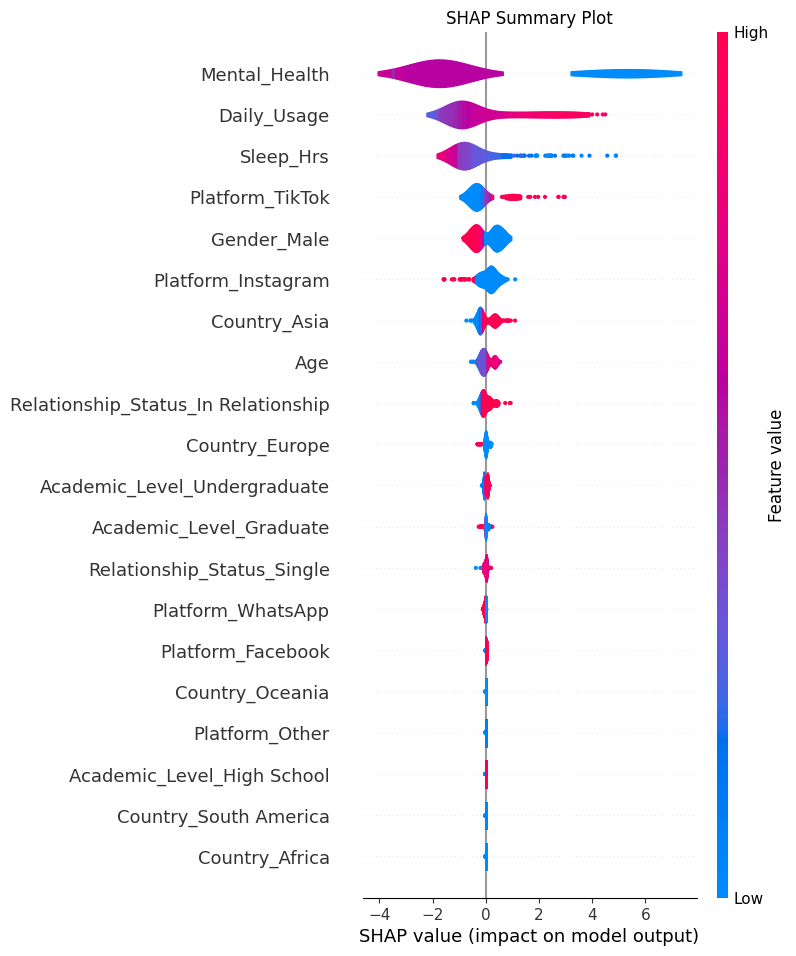

In [16]:
fig_sum = run_shap_experiment(
    best_model=best_xgb,
    X_train_full=X_train_full,
    feature_perturbation="interventional",
    plot_type="violin", # other options: "bar", "dot", "violin"
    shap_type="tree"
)

fig_sum

# Removing self-reported features
We drop mental health and relationship status features because they are self-reported and may not be accurate.

## Logistic Regression with Mental Health removed
- Without using mental health, the model's performance is slightly worse.
    - **10% drop in F1 score**.
    - **8% drop in Recall**.

In [17]:
numeric_cols = [c for c in numeric_cols if c != 'Mental_Health']

# Create a transformer that simply drops the Mental_Health_Score column
preprocessor_no_mh = ColumnTransformer([
    ('bools',   binary_transformer,   binary_cats),
    ('low_ohe', low_card_transformer, low_card_cols),
    ('high_ohe',high_card_transformer,high_card_cols),
    ('cty_ohe', country_transformer,  country_col),
    ('nums',    numeric_transformer,  numeric_cols),
], remainder='drop')

# Build a new pipeline that drops the column, then applies your old preprocessor
lr_pipeline_no_mh = Pipeline([
    ('preprocessing', preprocessor_no_mh),
    ('classifier',    LogisticRegression(random_state=42, max_iter=1000))
])

best_logreg_no_mh, grid_search_result_no_mh = run_classification_gridsearch_experiment(
    name="logreg_no_mh_gridsearch_f1",
    pipeline=lr_pipeline_no_mh,
    param_grid=param_grid_lr,
    X_train=X_train_full,
    y_train=y_train_full,
    X_test=X_test,
    y_test=y_test,
    cv=cv,
    scoring=scoring,
    dataset=mlflow_dataset,
    registered_model_name=f"conflict_lr_no_mh",
    verbose=True,
    feature_set="no_MH"
)


Fitting 5 folds for each of 32 candidates, totalling 160 fits
accuracy: 0.91 ± 0.03421648478980473
precision: 0.84 ± 0.07997525671205483
recall: 0.84 ± 0.0676502941129295
f1_score: 0.84 ± 0.06141379412747573
roc_auc: 0.96 ± 0.014766415719359703


/opt/anaconda3/envs/c29env/lib/python3.12/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
/Users/bobhosseini/Portfolio/SDS-social-sphere/submissions/team-members/bob-hosseini/notebooks/../src/utils.py:525: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


Best parameters: {'classifier__C': 0.1, 'classifier__class_weight': None, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best F1 score (CV): 0.8394927367618538


Registered model 'conflict_lr_no_mh' already exists. Creating a new version of this model...
Created version '9' of model 'conflict_lr_no_mh'.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__class_weight,param_classifier__penalty,param_classifier__solver,params,split0_test_accuracy,...,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,split3_train_roc_auc,split4_train_roc_auc,mean_train_roc_auc,std_train_roc_auc
14,0.004852,0.000395,0.009514,0.003499,0.1,None,l2,liblinear,"{'classifier__C': 0.1, 'classifier__class_weig...",0.929204,...,0.960202,0.014766,18,0.962887,0.961575,0.964222,0.967482,0.968602,0.964954,0.002680
12,0.004718,0.000792,0.006791,0.000785,0.1,None,l1,liblinear,"{'classifier__C': 0.1, 'classifier__class_weig...",0.911504,...,0.953909,0.016354,23,0.953028,0.950633,0.953680,0.959104,0.960097,0.955308,0.003662
22,0.006109,0.003061,0.008686,0.003510,1.0,None,l2,liblinear,"{'classifier__C': 1, 'classifier__class_weight...",0.929204,...,0.965476,0.011134,1,0.970167,0.970593,0.970945,0.973746,0.974688,0.972028,0.001829


## SHAP Analysis for Logistic Regression without Mental Health
- Without using mental health, Daily Usage and Sleep Hours gained more importance.

/opt/anaconda3/envs/c29env/lib/python3.12/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
/Users/bobhosseini/Portfolio/SDS-social-sphere/submissions/team-members/bob-hosseini/notebooks/../src/utils.py:525: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


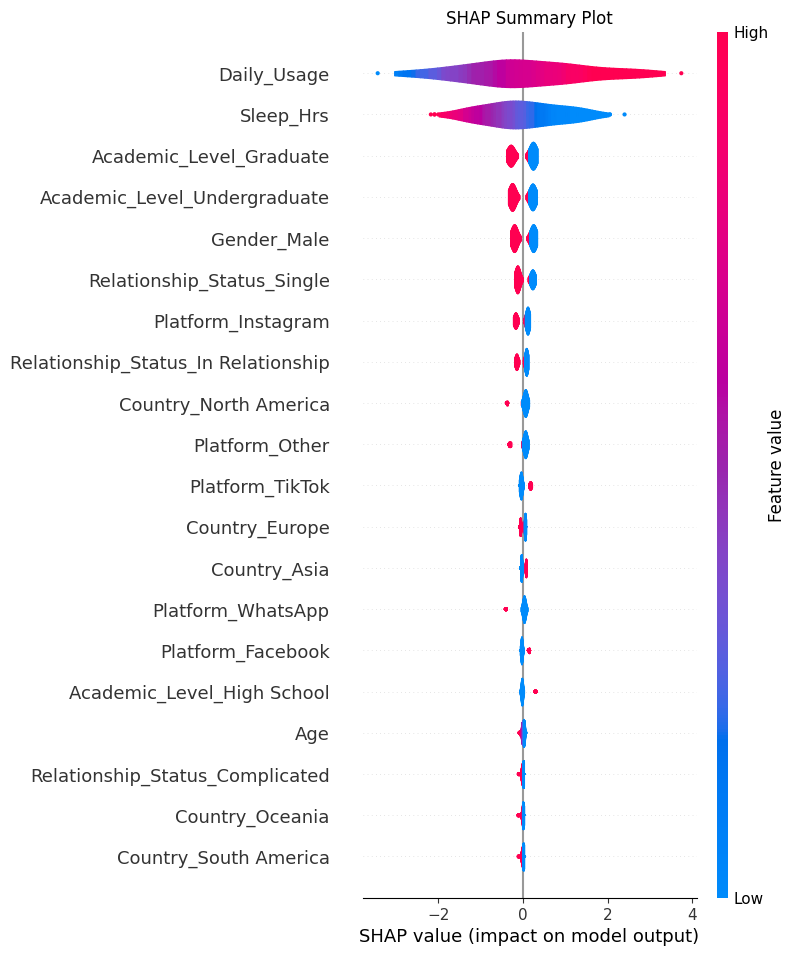

In [18]:
fig_sum = run_shap_experiment(
    best_model=best_logreg_no_mh,
    X_train_full=X_train_full,
    feature_perturbation="interventional",
    plot_type="violin", # other options: "bar", "dot", "violin"
    shap_type="linear"
)

fig_sum

## XGBoost with no Mental Health
- Removing Mental Health has less impact on XGBoost than Logistic Regression.
- The model's performance slightly droped by **4% in F1 score** and **3% in Recall**.
- Similar to the logistic regression model, the predictions of the XGBoost model are highly influenced by the **Daily Usage** and **Sleep Hours**.
- Also, without relying on mental health, being in an **Asian country** and the student's **Age** has gained more importance.

Fitting 5 folds for each of 24 candidates, totalling 120 fits
accuracy: 0.95 ± 0.012135610050800492
precision: 0.91 ± 0.03612610362851754
recall: 0.91 ± 0.0169398928063821
f1_score: 0.91 ± 0.02254567063851212
roc_auc: 0.98 ± 0.007392613154314083


/Users/bobhosseini/Portfolio/SDS-social-sphere/submissions/team-members/bob-hosseini/notebooks/../src/utils.py:525: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}
Best F1 score (CV): 0.9097082522923035


Registered model 'conflict_xgb_no_mh' already exists. Creating a new version of this model...
Created version '2' of model 'conflict_xgb_no_mh'.


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__n_estimators,param_classifier__subsample,params,split0_test_accuracy,...,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,split0_train_roc_auc,split1_train_roc_auc,split2_train_roc_auc,split3_train_roc_auc,split4_train_roc_auc,mean_train_roc_auc,std_train_roc_auc
18,0.017488,0.002593,0.009899,0.003918,0.1,5,200,0.8,"{'classifier__learning_rate': 0.1, 'classifier...",0.955752,...,0.976126,0.007120,12,1.000000,1.000000,0.999949,1.000000,1.000000,0.999990,0.000020
16,0.016957,0.005911,0.012483,0.006275,0.1,5,100,0.8,"{'classifier__learning_rate': 0.1, 'classifier...",0.955752,...,0.977499,0.007393,8,0.999719,0.999772,0.999389,0.999516,0.999618,0.999603,0.000138
12,0.013133,0.003290,0.010794,0.004560,0.1,3,100,0.8,"{'classifier__learning_rate': 0.1, 'classifier...",0.946903,...,0.974591,0.005218,16,0.998263,0.998252,0.997021,0.997021,0.998396,0.997790,0.000631


/Users/bobhosseini/Portfolio/SDS-social-sphere/submissions/team-members/bob-hosseini/notebooks/../src/utils.py:525: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


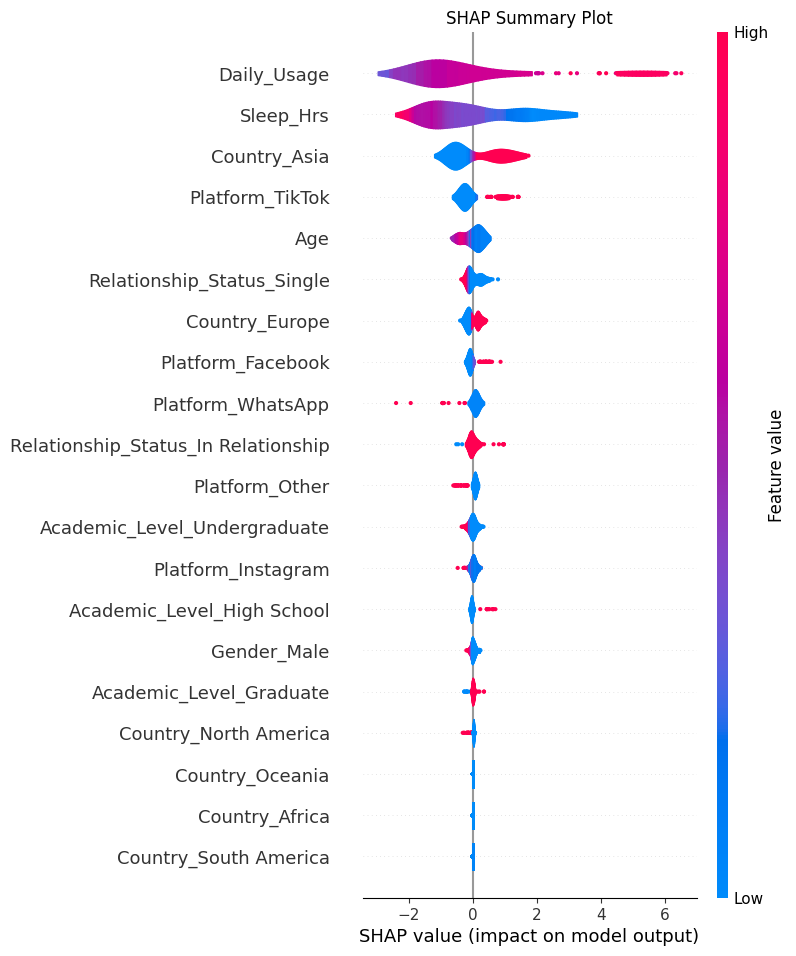

In [19]:
# Build the full pipeline
xgb_pipeline_no_mh = Pipeline([
    ('preprocessing', preprocessor_no_mh),   # your ColumnTransformer from earlier
    ('classifier',     xgb_clf)
])

best_xgb_no_mh, grid_search_result_no_mh = run_classification_gridsearch_experiment(
    name="xgb_no_mh_gridsearch_f1",
    pipeline=xgb_pipeline_no_mh,
    param_grid=xgb_param_grid,
    X_train=X_train_full,
    y_train=y_train_full,
    X_test=X_test,
    y_test=y_test,
    cv=cv,
    scoring=scoring,
    dataset=mlflow_dataset,
    registered_model_name=f"conflict_xgb_no_mh",
    feature_set="no_MH",
    verbose=True
)

fig_sum = run_shap_experiment(
    best_model=best_xgb_no_mh,
    X_train_full=X_train_full,
    feature_perturbation="interventional",
    plot_type="violin", # other options: "bar", "dot", "violin"
    shap_type="tree"
)

fig_sum